In [8]:
"""
    Apartado de importaciones y preparaciones iniciales
"""
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
import warnings
import os
RUTA_RECODE_DATASER ="recodes/"
RUTA_DATASET_INICIAL = "datasets/"
RUTA_DATASET_LIMPIADO = "01_dataset_limpiado/"
RUTA_DATASET_FRECUENCIA_GRUPOS = "02_frecuencia_grupos/"
RUTA_DATASET_GRUPOS_CONSOLIDADO = "04_consolidado_grupos/"
RUTA_DATASET_TOTALES_ENFERMEDADES = "05_frecuencias_totales/"

COLUMNAS_INICIALES_INTERES = ["ucr358", "sex", "ager52", "race"]
COLUMNAS_GRUPOS_INTERES = ["ucr358", "sex", "ager52", "race", "count", "year"]

NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO = "frecuencia_grupos_enfermedades.csv"
NOMBRE_ARCHIVO_CONSOLIDADO_TOTALES = "recuencias_grupos_enfermedades_total.csv"

COLUMNA_TOTAL = "count"

# Creando directorios en caso no se encuentren en el root
if(not os.path.exists(RUTA_DATASET_INICIAL)): os.makedirs(RUTA_DATASET_INICIAL)
if(not os.path.exists(RUTA_DATASET_LIMPIADO)): os.makedirs(RUTA_DATASET_LIMPIADO)
if(not os.path.exists(RUTA_DATASET_FRECUENCIA_GRUPOS)): os.makedirs(RUTA_DATASET_FRECUENCIA_GRUPOS)
if(not os.path.exists(RUTA_DATASET_GRUPOS_CONSOLIDADO)): os.makedirs(RUTA_DATASET_GRUPOS_CONSOLIDADO)
if(not os.path.exists(RUTA_DATASET_TOTALES_ENFERMEDADES)): os.makedirs(RUTA_DATASET_TOTALES_ENFERMEDADES)

In [3]:
"""
    01 - Algoritmo de limpiado y extraccion

    Objetivo:
    *) En base a los datasets iniciales, que cuentan con columnas innecesarias que se no se ocuparan en la investigacion
       el algoritmo de limpiado y extraccion busca guardar los datasets, solo con las columnas que se buscan estudiar
"""
carpeta_inicial = RUTA_DATASET_INICIAL
carpeta_destino = RUTA_DATASET_LIMPIADO
columnas_interes = COLUMNAS_INICIALES_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

for archivo in archivos_convertir:
    print("Convirtiendo: " + archivo)
    df_muertes = pd.read_csv(carpeta_inicial + archivo)
    df_resumido = df_muertes[columnas_interes]
    df_resumido.to_csv(carpeta_destino + archivo, index=False)
    print("Dataset almacenado")

Convirtiendo: 2019.csv


C:\Users\JRG\AppData\Local\Temp\ipykernel_19864\3170342760.py:15: DtypeWarning: Columns (66,69,72,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df_muertes = pd.read_csv(carpeta_inicial + archivo)


Dataset almacenado
Convirtiendo: 2020.csv


C:\Users\JRG\AppData\Local\Temp\ipykernel_19864\3170342760.py:15: DtypeWarning: Columns (66,69,72,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df_muertes = pd.read_csv(carpeta_inicial + archivo)


Dataset almacenado
Convirtiendo: 2021.csv


C:\Users\JRG\AppData\Local\Temp\ipykernel_19864\3170342760.py:15: DtypeWarning: Columns (69,72,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df_muertes = pd.read_csv(carpeta_inicial + archivo)


Dataset almacenado


In [5]:
"""
    02 - Algoritmo de agrupamiento

    Objetivo:
    *) En el paso anterior se realizó el proceso de extraccion y limpiado de datos para cada uno de los años 
       que se buscan estudiar, para este paso se busca saber la frecuencia de los grupos de interes, en este
       caso un grupo esta formado por:

        -> Genero
        -> Edad
        -> Raza
        -> Enfermedad
"""

carpeta_inicial = RUTA_DATASET_LIMPIADO
carpeta_destino = RUTA_DATASET_FRECUENCIA_GRUPOS
columnas_interes = COLUMNAS_INICIALES_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

count = 0

for archivo in archivos_convertir:
    print("Procesando agrupaciones para: " + archivo)
    df_muertes = pd.read_csv(carpeta_inicial + archivo)
    grupo = df_muertes.groupby(columnas_interes).size().sort_values(ascending=False)
    df_agrupado = grupo.reset_index().rename(columns = { 0: COLUMNA_TOTAL }).sort_values(by = columnas_interes)
    # Agregando el año de todas las filas (para distinguir el año de procedencia de la data)
    df_agrupado["year"] = int(archivo.split(".")[0])
    df_agrupado.to_csv(carpeta_destino + archivo, index=False)
    count = df_agrupado[COLUMNA_TOTAL].sum()
    print("Totales de muertes en el año: " + str(count))
    print("Agrupaciones almacenadas")

Procesando agrupaciones para: 2019.csv
Totales de muertes en el año: 2861523
Agrupaciones almacenadas
Procesando agrupaciones para: 2020.csv
Totales de muertes en el año: 3390278
Agrupaciones almacenadas
Procesando agrupaciones para: 2021.csv
Totales de muertes en el año: 0
Agrupaciones almacenadas


In [3]:
"""
    03 - Algoritmo de estandarización
"""
recode2019 = pd.read_json('recodes/recode2019.json')
recode2020 = pd.read_json('recodes/recode2020.json')
recode2021 = pd.read_json('recodes/recode2021.json')

claves_a_comparar = [i for i in range(1, 457)] 
claves_y_valores_diferentes = []

# Realiza la comparación recursiva
for clave in claves_a_comparar:
    valor_df1 = recode2019.loc[clave, "358_cause_recode"]
    valor_df2 = recode2020.loc[clave, "358_cause_recode"]
    valor_df3 = recode2021.loc[clave, "358_cause_recode"]

    if valor_df1 != valor_df2 or valor_df1 != valor_df3 or valor_df2 != valor_df3:
        claves_y_valores_diferentes.append((clave, valor_df1, valor_df2, valor_df3))

# Muestra las claves con valores diferentes y sus valores respectivos
if claves_y_valores_diferentes:
    print("Las claves con valores diferentes son:")
    for clave, valor_df1, valor_df2, valor_df3 in claves_y_valores_diferentes:
        print(f"Clave: {clave}, Valor en df1: {valor_df1}, Valor en df2: {valor_df2}, Valor en df3: {valor_df3}")
else:
    print("Todos los valores son iguales para las claves '1' a '456' en los tres DataFrames.")

C:\Users\JRG\AppData\Local\Temp\ipykernel_5072\1160224694.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  recode2019 = pd.read_json('recodes/recode2019.json')
C:\Users\JRG\AppData\Local\Temp\ipykernel_5072\1160224694.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  recode2019 = pd.read_json('recodes/recode2019.json')
C:\Users\JRG\AppData\Local\Temp\ipykernel_5072\1160224694.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In 

KeyError: 1

In [4]:
"""
    04 - Algoritmo de consolidación y agrupación final
    
    Objetivo:
    *) En los pasos previos, hemos obtenido los datasets que representan las frecuencias de las enfermedades de un
       año determinado para nuestras columnas de interes (Genero, Edad, Raza, Enfermedad), este paso simplemente busca
       consolidar en un archivo el resultado de las frecuencias de cada uno de los años de estudio
"""
carpeta_inicial = RUTA_DATASET_FRECUENCIA_GRUPOS
carpeta_destino = RUTA_DATASET_GRUPOS_CONSOLIDADO
columnas_interes = COLUMNAS_GRUPOS_INTERES
archivos_convertir = os.listdir(carpeta_inicial)

primer_archivo = True
df_grupos_consolidado = ""
count = 0

for archivo in archivos_convertir:
    if (primer_archivo):
        df_grupos_consolidado = pd.read_csv(carpeta_inicial + archivo)
        primer_archivo = False
    else:
        df_grupo_anio = pd.read_csv(carpeta_inicial + archivo)
        df_grupos_consolidado = pd.concat([df_grupos_consolidado, df_grupo_anio], axis=0, ignore_index=True)

# Almacenando consolidado final de enfermedades por anio
df_grupos_consolidado.to_csv(carpeta_destino + NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO, index=False)
count = df_grupos_consolidado[COLUMNA_TOTAL].sum()
print("Totales de muertes para los años procesados: " + str(count))
print("Consolidado de frecuencias por enfermedad almacenado exitosamente")

Totales de muertes para los años procesados: 6251801
Consolidado de frecuencias por enfermedad almacenado exitosamente


In [6]:
"""
    05 - Algoritmo de análisis

    Objetivo:
    *) Ahora que ya tenemos las frecuencias de muerte para cada grupo, procedemos a ejecutar el algoritmo de probabilidad
       de muerte de una persona por una enfermedad, el algoritmo es el siguiente:
    
    P(muerte persona, dada [ENTRADA]) =     # de personas que han muerto dada [ENTRADA]
                                        ---------------------------------------------------
                                        # de personas que han muerto para el [GENERO] dado

    Entrada:
    *) Genero
    *) Rango de edad
    *) Raza
    *) Enfermedad
"""

carpeta_inicial = RUTA_DATASET_GRUPOS_CONSOLIDADO
carpeta_destino = RUTA_DATASET_TOTALES_ENFERMEDADES
columnas_interes = COLUMNAS_INICIALES_INTERES
archivo_entrada = NOMBRE_ARCHIVO_CONSOLIDADO_FREC_GRUPO
archivo_salida = NOMBRE_ARCHIVO_CONSOLIDADO_TOTALES

"""
    FUNCION CALCULADORA DE PROBABILIDAD DE MUERTE
"""
def probabilidad_muerte(df, v_genero, v_rango_edad, v_raza, v_enfermedad):
    # Paso 1: Chequear si tenemos la cantidad de personas muertas, dada las variables de entrada
    grupo_interes = df[
        (df["sex"] == v_genero) 
        & (df["ager52"] == v_rango_edad) 
        & (df["race"] == v_raza)
        & (df["ucr358"] == v_enfermedad)]
    
    if (not grupo_interes.empty):
        # Paso 2: ya que encontramos al grupo que pertenece, determinamos en total para el genero, las personas
        #           que mueren, para conocer la probabilidad que dicha persona podria morir, dada las condiciones
        
        # determinando el numero de personas muertas para un genero dado, para una enfermedad dada
        grupo_total = df[(df["sex"] == genero) & (df["ucr358"] == enfermedad)]
        
        total_muertes = grupo_total[COLUMNA_TOTAL].sum()
        muertes_grupo_interes = grupo_interes[COLUMNA_TOTAL].sum()

        # Print para propositos de debugging
        print("Numero de muertes para la enfermedad entre todos los " +  genero + " :" + str(total_muertes))
        print("Numero de muertes para el grupo al que pertenece la persona: " +  str(muertes_grupo_interes))
        print("Probabilidad de que la persona muera: " + str(muertes_grupo_interes/total_muertes))
        print("")

        return muertes_grupo_interes/total_muertes
    else:
        # -1 = data no fue encontrada para el grupo de interes
        return -1
    

"""
    Codigo ejecucion
"""

# Paso 1: Cargamos el dataset, y lo reagrupamos de tal manera que, se sumen la columna "count" para obtener el total
#         de muertos por enfermedad para cada grupo de interes
df_frecuencias_enfermedades_anio = pd.read_csv(carpeta_inicial + archivo_entrada)
df_frecuencias_enfermedades_total = df_frecuencias_enfermedades_anio.groupby(columnas_interes)[COLUMNA_TOTAL].sum().reset_index().sort_values(by = [COLUMNA_TOTAL])
df_frecuencias_enfermedades_total.to_csv(carpeta_destino + archivo_salida, index = False)


# Paso 2: Calculamos las probabilidades para las enfermedades

# Variables de entrada
genero = "F"
rango_edad = 44
raza = 1
enfermedad = 175

resultado = probabilidad_muerte(df_frecuencias_enfermedades_total, genero, rango_edad, raza, enfermedad)
print("Probabilidad de que la persona muera por la enfermedad (%): " + str(resultado*100))
print("Total de muertes por todos los datasets: " + str(df_frecuencias_enfermedades_total[COLUMNA_TOTAL].sum()))


Numero de muertes para la enfermedad entre todos los F :159675
Numero de muertes para el grupo al que pertenece la persona: 39807
Probabilidad de que la persona muera: 0.24930014091122593

Probabilidad de que la persona muera por la enfermedad (%): 24.930014091122594
Total de muertes por todos los datasets: 6251801


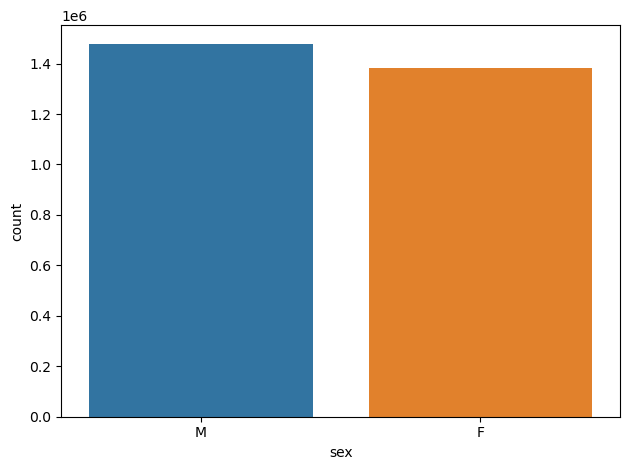

In [13]:
# Grafico 1: Muertes por genero para cada año estudiado
carpeta_inicial = RUTA_DATASET_LIMPIADO
anio = 2019
archivo = str(anio) + ".csv"

df = pd.read_csv(carpeta_inicial + archivo)
countplot = sns.countplot(df, x="sex")
countplot.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

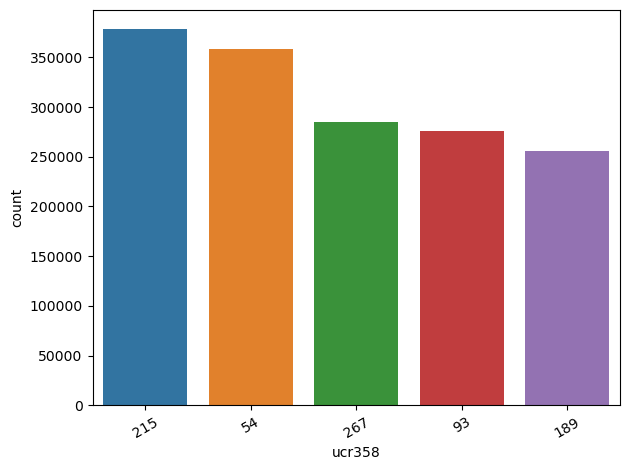

In [15]:
# Grafico 2: Grafico de las 5 enfermedades con mayor numero de muertes en los 2 años de estudio
carpeta_inicial = RUTA_DATASET_LIMPIADO

df_2019 = pd.read_csv(carpeta_inicial + "2019.csv")
df_2020 = pd.read_csv(carpeta_inicial + "2020.csv")
df_consolidado = pd.concat([df_2019, df_2020], axis=0, ignore_index=True)

order = df_consolidado["ucr358"].value_counts().index
countplot = sns.countplot(df_consolidado, x="ucr358", order=order[:5])
countplot.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

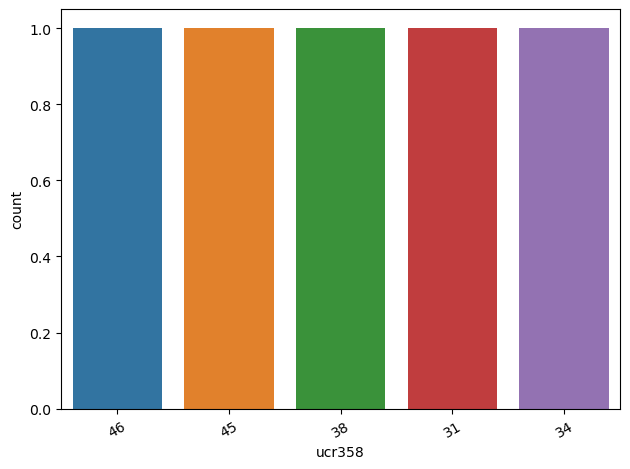

In [17]:
# Grafico 3: Grafico de las 5 enfermedades con el menor numero de muertes, para los 2 años estudiados

carpeta_inicial = RUTA_DATASET_LIMPIADO

df_2019 = pd.read_csv(carpeta_inicial + "2019.csv")
df_2020 = pd.read_csv(carpeta_inicial + "2020.csv")
df_consolidado = pd.concat([df_2019, df_2020], axis=0, ignore_index=True)

order = df_consolidado["ucr358"].value_counts().index
countplot = sns.countplot(df_consolidado, x="ucr358", order=order[-5:])
countplot.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

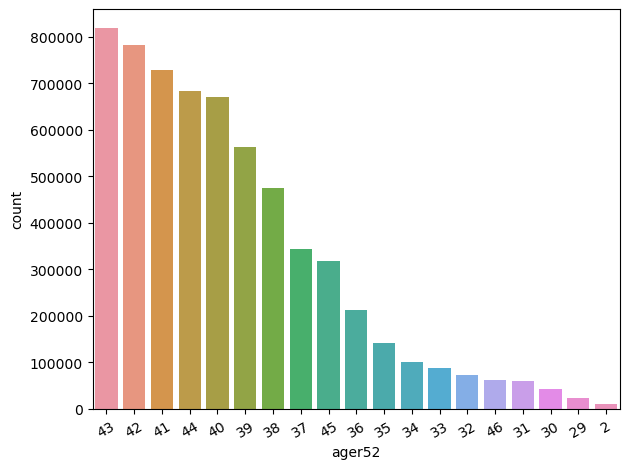

In [22]:
# Grafico 4: Grafico de rango de edades con el mayor numero de muertes, para los 2 años estudiados
carpeta_inicial = RUTA_DATASET_LIMPIADO

df_2019 = pd.read_csv(carpeta_inicial + "2019.csv")
df_2020 = pd.read_csv(carpeta_inicial + "2020.csv")
df_consolidado = pd.concat([df_2019, df_2020], axis=0, ignore_index=True)

order = df_consolidado["ager52"].value_counts().index
countplot = sns.countplot(df_consolidado, x="ager52", order=order[:19])
countplot.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()